# Partisan domain bias score analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
dem_rep_prop = pd.read_csv('../data/house_analysis/domain_dem_rep_prop.csv')

In [4]:
ron_news = pd.read_csv('../data/bias_score_ron_2018.csv')

In [7]:
domain_ratings = ron_news[ron_news['domain'].isin(dem_rep_prop.domain)]

In [8]:
all_domain_leaning_prop = pd.merge(dem_rep_prop, domain_ratings[['domain', 'bias_score']].drop_duplicates(), how="left", on='domain')

In [9]:
all_domain_leaning_prop

,domain,dem_prop,rep_prop,bias_score
0,Katko,0.000000e+00,3.570443e-09,NaN
1,100e53.com,2.561136e-08,0.000000e+00,NaN
2,1011now.com,2.148793e-05,4.551387e-04,0.5387
3,101espn.com,0.000000e+00,1.553143e-06,NaN
4,1057news.com,2.845707e-09,0.000000e+00,NaN
...,...,...,...,...
8846,zimmerlaw.com,1.138283e-08,0.000000e+00,NaN
8847,zocdoc.com,8.821692e-08,0.000000e+00,NaN
8848,zoelofgren.com,2.409289e-04,0.000000e+00,NaN
8849,zoominfo.com,1.337482e-07,0.000000e+00,NaN


In [46]:
all_domain_leaning_prop.to_csv("../data/house_analysis/domain_party_proportion_with_biasscore.csv", index=False)

In [14]:
# Coverage rate
len(all_domain_leaning_prop.dropna())/len(all_domain_leaning_prop)

0.261439385380183

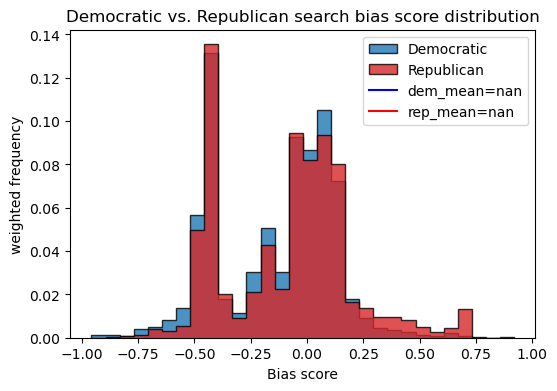

In [10]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.hist(all_domain_leaning_prop['bias_score'], edgecolor='black', bins=30, weights=all_domain_leaning_prop['dem_prop'], 
         histtype='step', fill=True, color='#1f77b4', label='Democratic', alpha = 0.8)
plt.hist(all_domain_leaning_prop['bias_score'], edgecolor='black', bins=30, weights=all_domain_leaning_prop['rep_prop'], 
         histtype='step', fill=True, color='#d62728', label='Republican', alpha = 0.8)

dem_weighted_avg = np.average(all_domain_leaning_prop['bias_score'], weights=all_domain_leaning_prop['dem_prop'])
plt.axvline(x = dem_weighted_avg, color = 'b',label = 'dem_mean='+str(round(dem_weighted_avg, 3)))
rep_weighted_avg = np.average(all_domain_leaning_prop['bias_score'], weights=all_domain_leaning_prop['rep_prop'])
plt.axvline(x = rep_weighted_avg, color = 'r',label = 'rep_mean='+str(round(rep_weighted_avg, 3)))
plt.legend()
 
plt.xlabel('Bias score')
plt.ylabel('weighted frequency')
plt.title("Democratic vs. Republican search bias score distribution")
plt.savefig("../data/plots/dem_rep_bias_score_dist.png", bbox_inches='tight', dpi=200) 
plt.show()

## Stats test on the difference between distribution for all type domains

In [20]:
# define weighted ks test
# code from https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

In [26]:
all_domain_leaning_prop.dropna(inplace=True)

In [27]:
all_domain_leaning_prop

,domain,dem_prop,rep_prop,bias_score
2,1011now.com,2.148793e-05,0.000455,0.5387
5,10news.com,6.464593e-05,0.000000,0.3315
6,10tv.com,1.220808e-04,0.000151,0.1897
8,11alive.com,2.810762e-04,0.000299,0.1956
9,12news.com,7.532587e-05,0.000073,0.1167
...,...,...,...,...
8834,yourerie.com,4.954376e-06,0.000139,0.2428
8836,yourobserver.com,0.000000e+00,0.000095,0.4942
8839,youthtoday.org,8.502973e-06,0.000000,-0.4904
8840,youtube.com,5.415998e-03,0.006232,0.1282


In [34]:
bias_scores = np.array(all_domain_leaning_prop['bias_score'])
dem_prop = np.array(all_domain_leaning_prop['dem_prop'])
rep_prop = np.array(all_domain_leaning_prop['rep_prop'])

d, p = ks_weighted(bias_scores, bias_scores, dem_prop, rep_prop, alternative='two-sided')

In [35]:
d, p

(np.float64(0.07286796750819358), np.float64(8.680594077609265e-06))

# News only

In [37]:
allison_cat = pd.read_csv("../data/domain_category.csv")

In [38]:
cleaned_cat = allison_cat[['domain','category']].drop_duplicates()

In [39]:
all_domain_leaning_prop_cat = pd.merge(all_domain_leaning_prop, cleaned_cat, how="left", on='domain')

In [40]:
all_domain_leaning_prop_cat

,domain,dem_prop,rep_prop,bias_score,category
0,1011now.com,2.148793e-05,0.000455,0.5387,news
1,10news.com,6.464593e-05,0.000000,0.3315,news
2,10tv.com,1.220808e-04,0.000151,0.1897,news
3,11alive.com,2.810762e-04,0.000299,0.1956,news
4,12news.com,7.532587e-05,0.000073,0.1167,news
...,...,...,...,...,...
2309,yourerie.com,4.954376e-06,0.000139,0.2428,news
2310,yourobserver.com,0.000000e+00,0.000095,0.4942,news
2311,youthtoday.org,8.502973e-06,0.000000,-0.4904,news
2312,youtube.com,5.415998e-03,0.006232,0.1282,social


In [41]:
news_leaning = all_domain_leaning_prop_cat[all_domain_leaning_prop_cat["category"]=="news"]

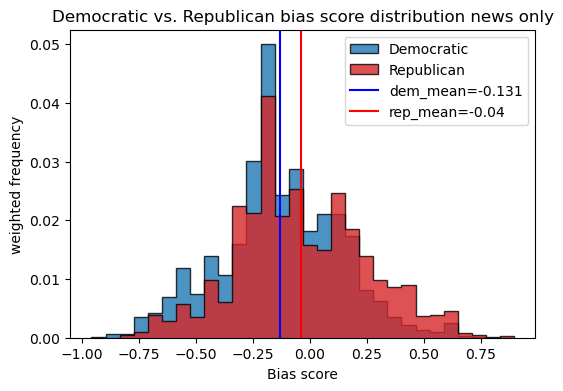

In [43]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.hist(news_leaning['bias_score'], edgecolor='black', bins=30, weights=news_leaning['dem_prop'], 
         histtype='step', fill=True, color='#1f77b4', label='Democratic', alpha = 0.8)
plt.hist(news_leaning['bias_score'], edgecolor='black', bins=30, weights=news_leaning['rep_prop'], 
         histtype='step', fill=True, color='#d62728', label='Republican', alpha = 0.8)

dem_weighted_avg = np.average(news_leaning['bias_score'], weights=news_leaning['dem_prop'])
plt.axvline(x = dem_weighted_avg, color = 'b',label = 'dem_mean='+str(round(dem_weighted_avg, 3)))
rep_weighted_avg = np.average(news_leaning['bias_score'], weights=news_leaning['rep_prop'])
plt.axvline(x = rep_weighted_avg, color = 'r',label = 'rep_mean='+str(round(rep_weighted_avg, 3)))
plt.legend()
 
plt.xlabel('Bias score')
plt.ylabel('weighted frequency')
plt.title("Democratic vs. Republican bias score distribution news only")
plt.savefig("../data/plots/dem_rep_news_bias_score_dist.png", bbox_inches='tight', dpi=200) 
plt.show()

In [44]:
bias_scores2 = np.array(news_leaning['bias_score'])
dem_prop2 = np.array(news_leaning['dem_prop'])
rep_prop2 = np.array(news_leaning['rep_prop'])

d2, p2 = ks_weighted(bias_scores2, bias_scores2, dem_prop2, rep_prop2, alternative='two-sided')

In [45]:
d2, p2

(np.float64(0.13775601562331463), np.float64(4.34911167937348e-16))